<a href="https://colab.research.google.com/github/zhanglix/atari_games/blob/master/gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install gym gym[atari] pyvirtualdisplay #> /dev/null 2>&1
# !apt update
# !apt-get install -y xvfb python-opengl ffmpeg #> /dev/null 2>&1

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from unittest.mock import MagicMock


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 200))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '200x200x24', ':1021'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '200x200x24', ':1021'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = sorted(glob.glob('video/*.mp4'))
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    gymlogger.debug('show video: path=%s', mp4)

    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                 controls >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, directory='./video', fake_reset=False):
  wenv = Monitor(env, directory, force=True)
  if fake_reset:
        wenv._before_reset()
        wenv._after_reset(None)
  return wenv

def safe_close(wenv):
    mock = MagicMock()
    mock.spec = wenv.env.spec
    wenv.env = mock
    wenv.close()

In [5]:
env = gym.make('Seaquest-v0')
wenv = wrap_env(env)
observation = wenv.reset()

for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()

safe_close(wenv)
show_video()

In [6]:
wenv = wrap_env(env, fake_reset=True)
for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()

safe_close(wenv)
show_video()

In [7]:
env = gym.make('Seaquest-v0')
observation = env.reset()
print(observation.shape)

(210, 160, 3)


In [8]:
def crop_image(img, start=20, height=160):
    return img[start:start+160]

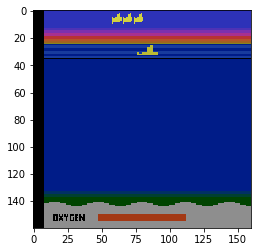

In [9]:
plt.imshow(crop_image(observation))

In [10]:
action_size = env.action_space.n
print(action_size)

18


In [11]:
def add_lstm_layer(input, units, initial_states, final_states, **kwargs):
    initial_memory_state = tf.keras.Input(shape=[units])
    initial_carry_state = tf.keras.Input(shape=[units])
    initial_state = [initial_memory_state, initial_carry_state]
    lstm = tf.keras.layers.LSTM(units, stateful=False, return_state=True, return_sequences=True,**kwargs)
    output, final_memory_state, final_carry_state = lstm(input, initial_state=initial_state)
    final_state =  [final_memory_state, final_carry_state]
    initial_states.append(initial_state)
    final_states.append(final_state)
    return output

def get_base_model(inputs, **kwargs):
    initail_states = []
    final_states = []
    x = tf.keras.layers.Conv2D(8, 3, strides=(2, 2), activation='relu', **kwargs)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu', **kwargs)(x)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu', **kwargs)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 0),name='to_sequence')(x)
    x = add_lstm_layer(x, 128, initail_states, final_states, **kwargs)
    x = add_lstm_layer(x, 128, initail_states, final_states, **kwargs)
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0),name='to_batch')(x)
    feature = tf.keras.layers.Dense(64, activation='relu', name="base_feature", **kwargs)(x)
    return tf.keras.Model(inputs =[inputs, initail_states], outputs=[feature, final_states])
        
    

In [205]:
class EntropyRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, scale=0.1, from_logits=True):
        self.scale=scale
        self.from_logits=from_logits
    def __call__(self, x):
        entropy = tf.keras.losses.categorical_crossentropy(x, x, from_logits=self.from_logits)
        return self.scale * tf.math.reduce_sum(entropy)
        

In [13]:
def get_action_model(action_size, **regularizers):
    screen = tf.keras.Input(shape=(160,160,3), name="screen")
    base_model = get_base_model(screen, **regularizers)
    logits = tf.keras.layers.Dense(action_size, name="logits", 
                                   activity_regularizer=EntropyRegularizer(),
                                   **regularizers)(base_model.output[0])
    action = tf.keras.layers.Lambda(lambda x: tf.random.categorical(x, 1), name='action')(logits)
    return tf.keras.Model(inputs = base_model.input, outputs=[action, base_model.output[1]], name="action")


In [14]:
def get_a3c_model(action_size, **regularizers):
    action_model = get_action_model(action_size, **regularizers)
    return get_a3c_model_from_action(action_model, **regularizers)
    
def get_a3c_model_from_action(action_model, **regularizers):
    feature = action_model.get_layer(name="base_feature").output
    score = tf.keras.layers.Dense(1, name="state_score",**regularizers)(feature)
    outputs = [action_model.output[0], score, action_model.output[1]]
    return tf.keras.Model(inputs = action_model.input, outputs=outputs)

In [15]:
class SparseCategorialCrossEntropy(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.losses.sparse_categorical_crossentropy(inputs[0], inputs[1], from_logits=True)

    

In [175]:
def get_train_model_from(a3c_model):
    target_score = tf.keras.Input(shape=tuple(), name="target_score")
    sample_action = tf.keras.Input(shape=tuple(), dtype=tf.int32, name="sample_action")
    state_score = a3c_model.get_layer(name="state_score").output
    logits = a3c_model.get_layer(name="logits").output
    cross_entropy=SparseCategorialCrossEntropy(name="logits_cross_entrofy")([sample_action, logits])
    action_gain = tf.keras.layers.Subtract(name="action_gain", 
                                           activity_regularizer=lambda x: tf.math.reduce_sum(tf.math.square(x)))
    action_gain = action_gain([target_score, state_score])
    action_loss = tf.keras.layers.Multiply(name="action_loss",
                                           activity_regularizer=tf.math.reduce_sum)
    action_loss = action_loss([cross_entropy, action_gain])
    return tf.keras.Model(inputs= [a3c_model.input, sample_action, target_score],
                          outputs = action_loss)

In [206]:
a3c_model = get_a3c_model(action_size, kernel_regularizer="l1_l2", bias_regularizer="l1_l2")
train_model =  get_train_model_from(a3c_model)

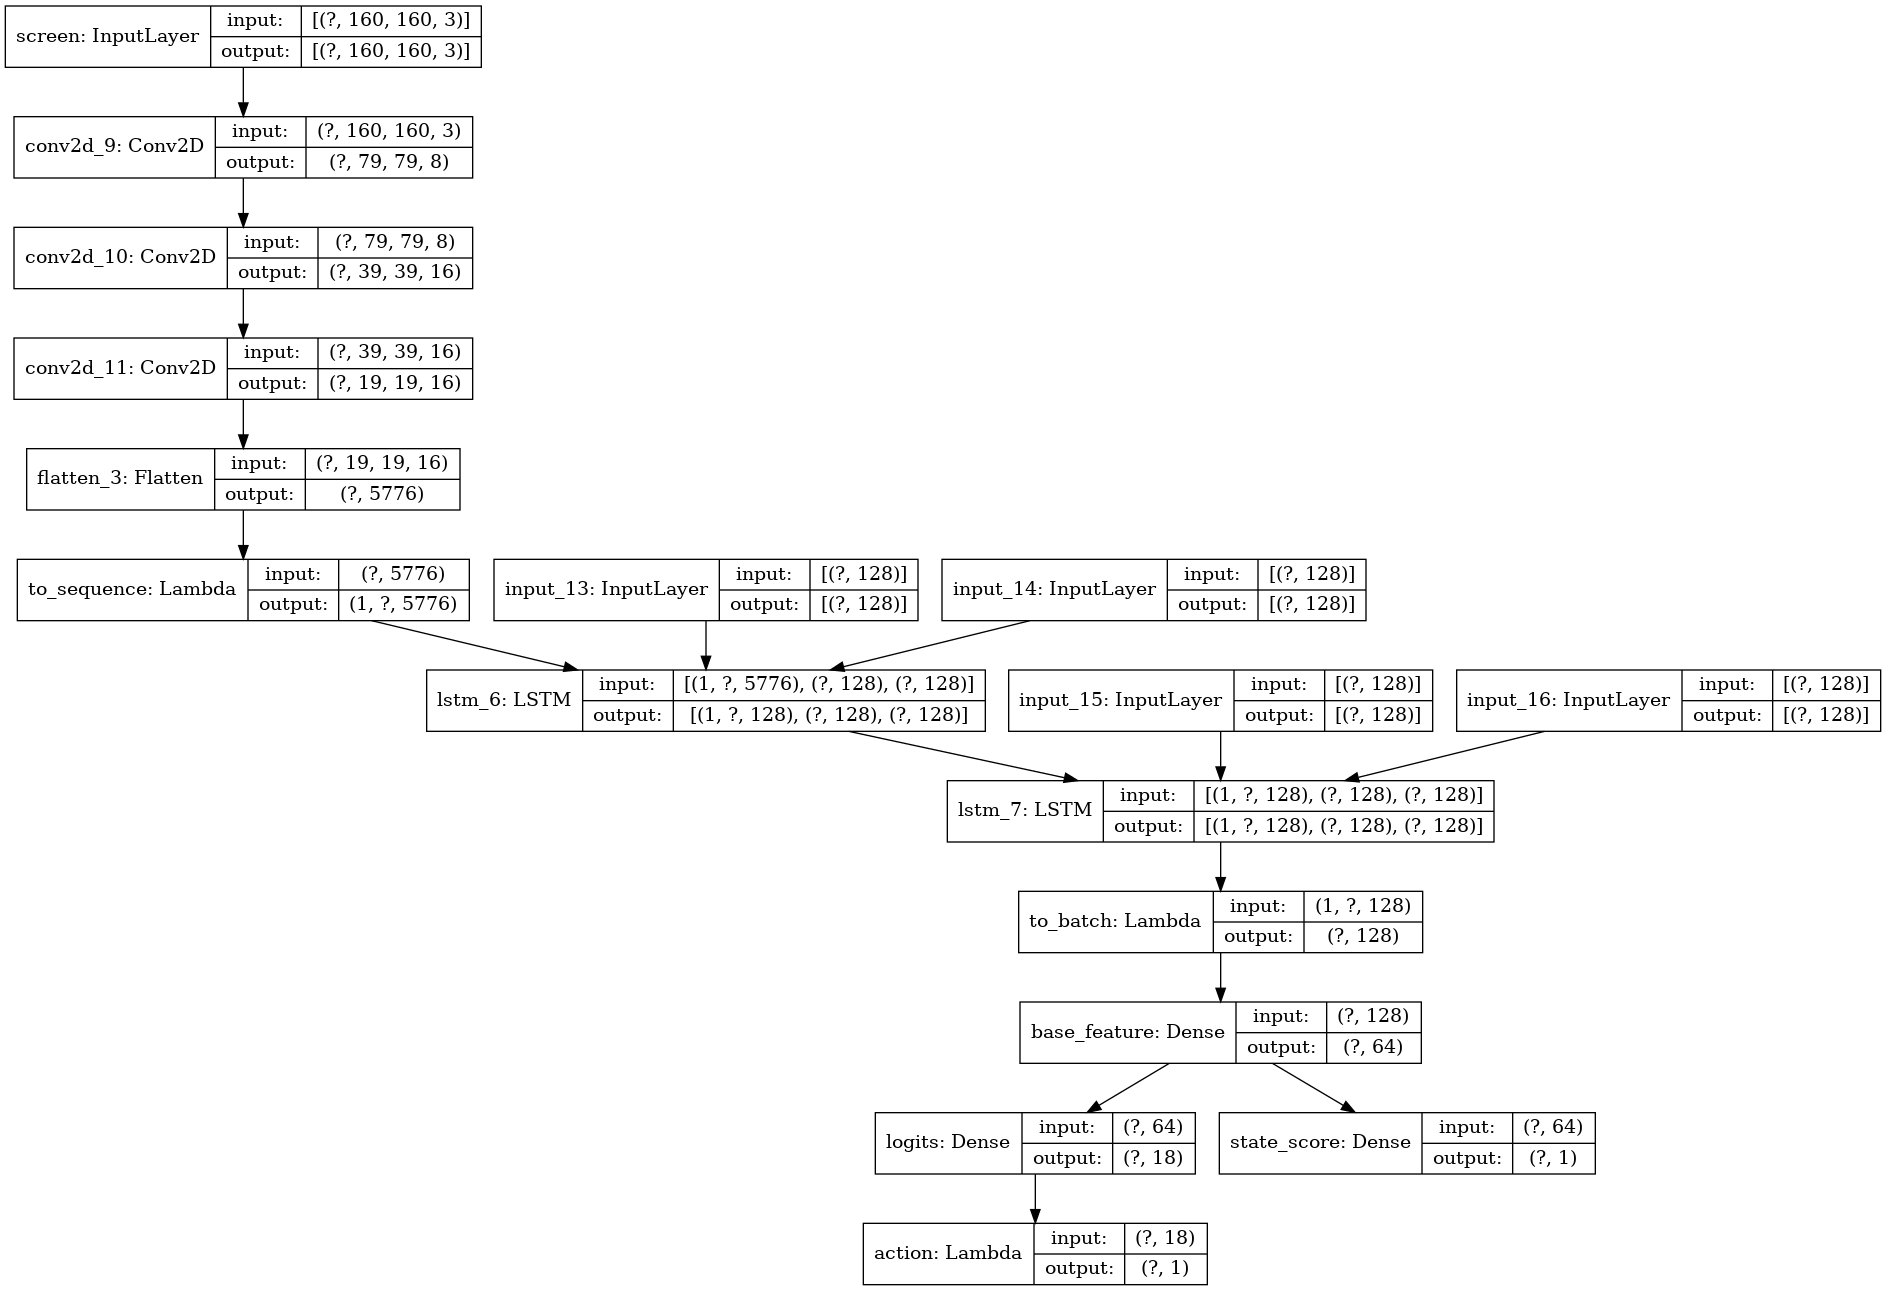

In [207]:
tf.keras.utils.plot_model(a3c_model, show_shapes=True)

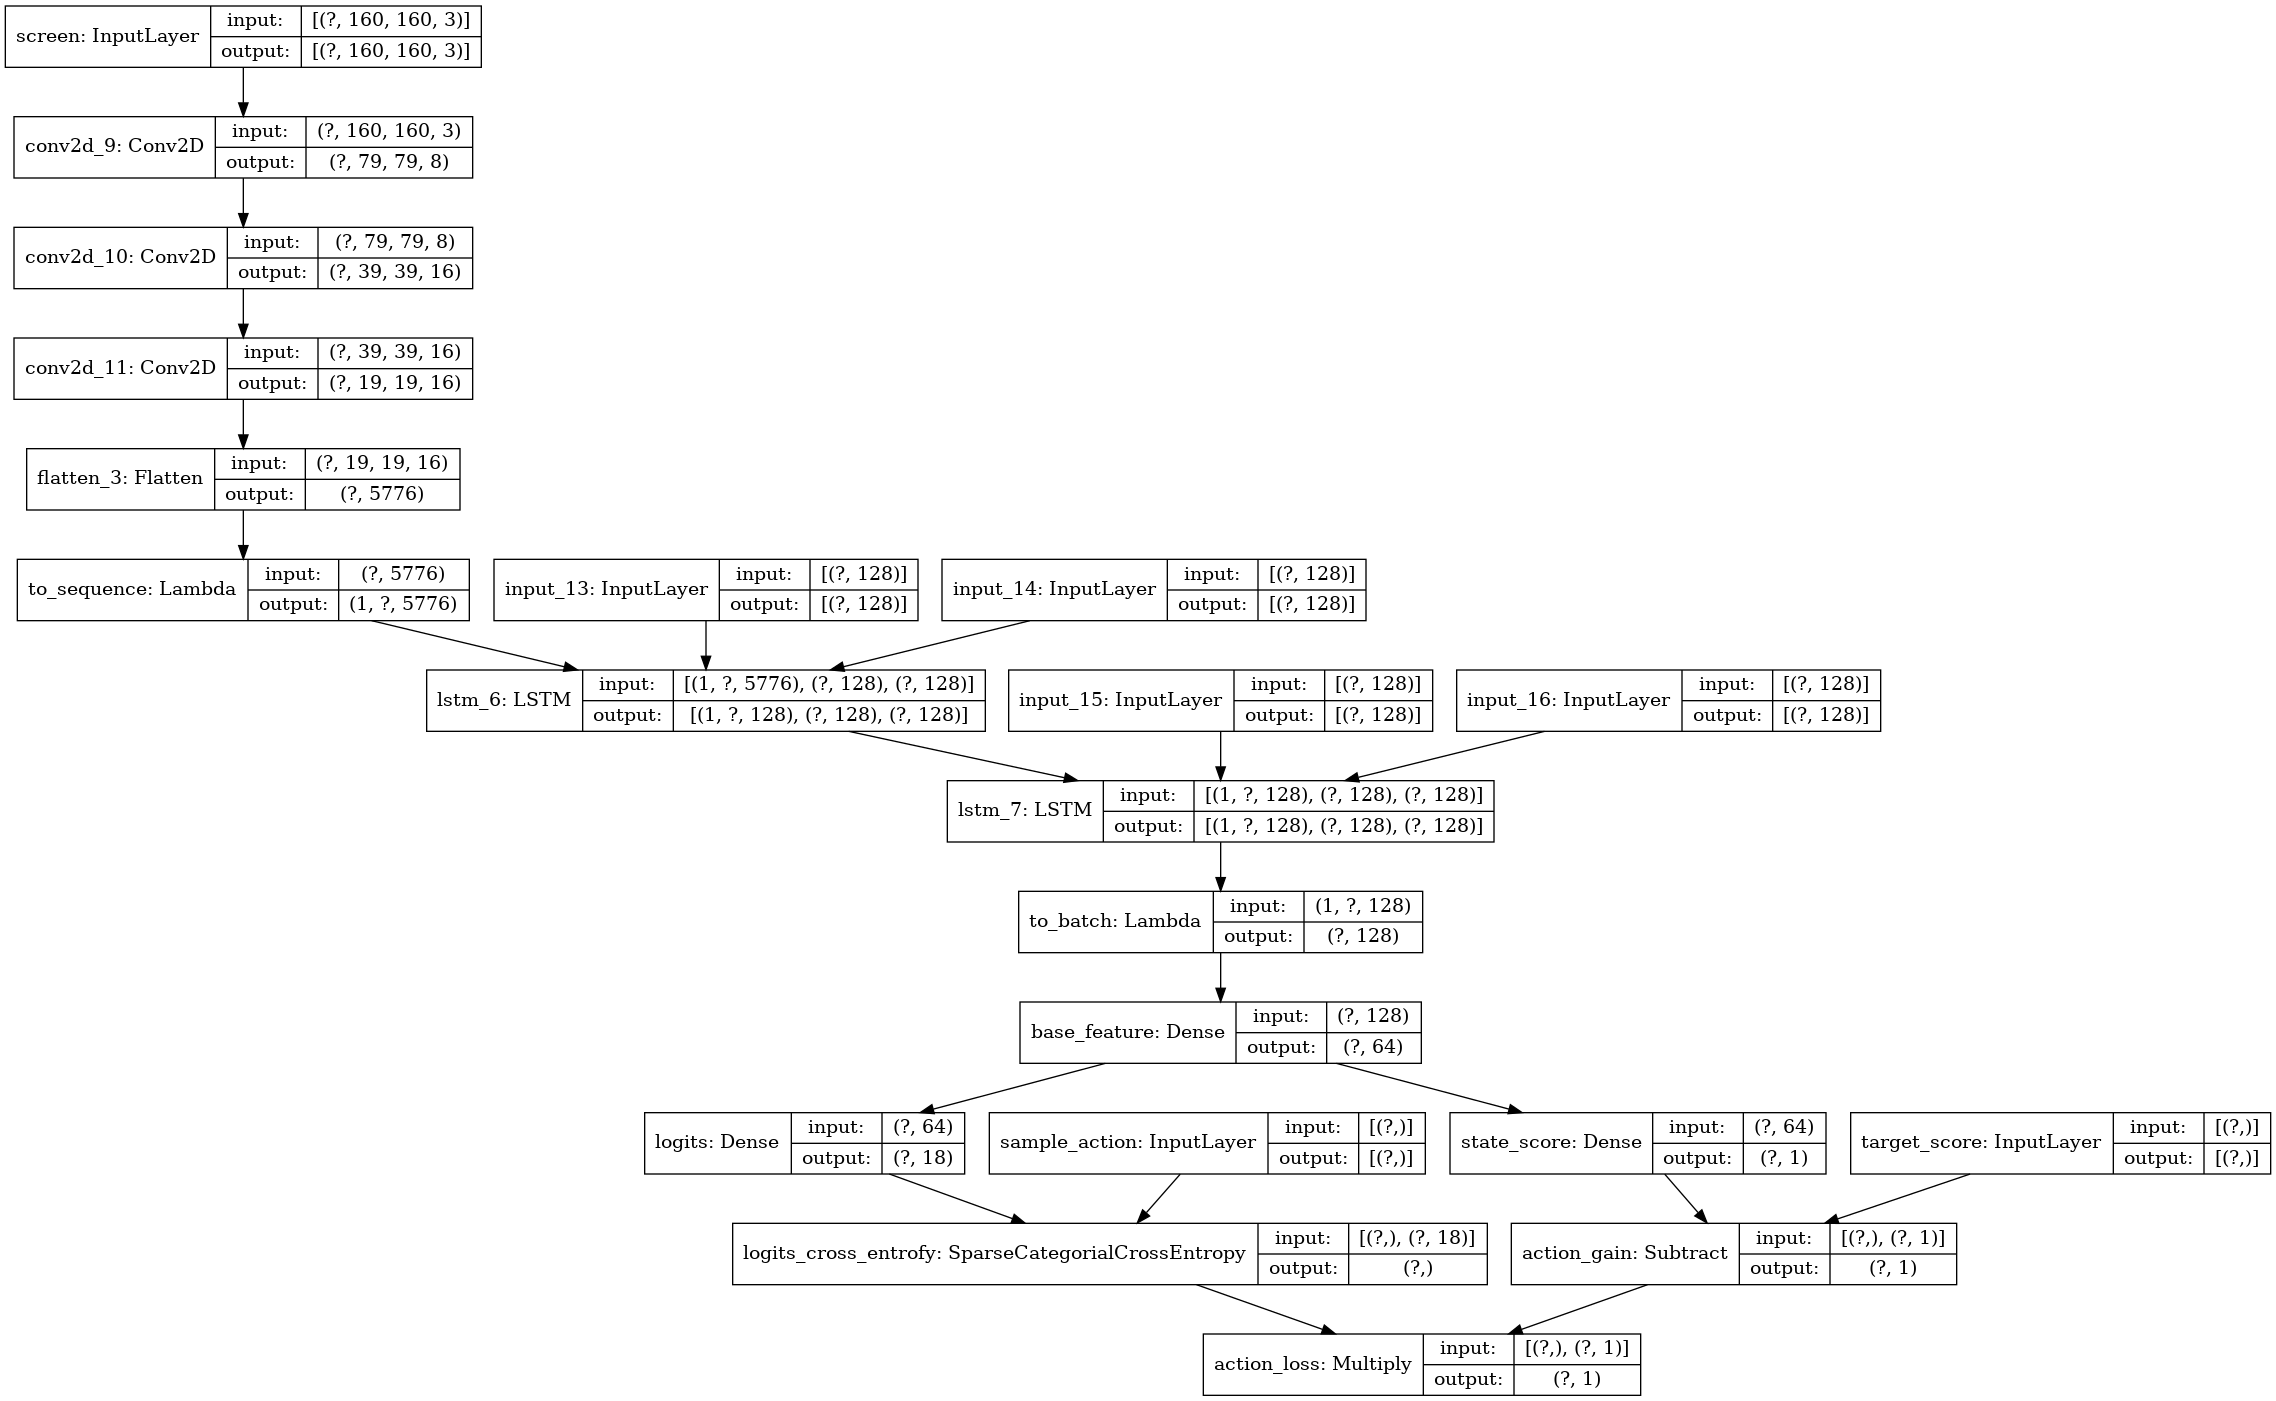

In [208]:
tf.keras.utils.plot_model(train_model, show_shapes=True)

In [209]:
"input:", a3c_model.input,"output:", a3c_model.output

('input:',
 [<tf.Tensor 'screen_3:0' shape=(None, 160, 160, 3) dtype=float32>,
  [[<tf.Tensor 'input_13:0' shape=(None, 128) dtype=float32>,
    <tf.Tensor 'input_14:0' shape=(None, 128) dtype=float32>],
   [<tf.Tensor 'input_15:0' shape=(None, 128) dtype=float32>,
    <tf.Tensor 'input_16:0' shape=(None, 128) dtype=float32>]]],
 'output:',
 [<tf.Tensor 'action_3/Identity:0' shape=(None, 1) dtype=int64>,
  <tf.Tensor 'state_score_3/Identity:0' shape=(None, 1) dtype=float32>,
  [[<tf.Tensor 'lstm_6/Identity_1:0' shape=(None, 128) dtype=float32>,
    <tf.Tensor 'lstm_6/Identity_2:0' shape=(None, 128) dtype=float32>],
   [<tf.Tensor 'lstm_7/Identity_1:0' shape=(None, 128) dtype=float32>,
    <tf.Tensor 'lstm_7/Identity_2:0' shape=(None, 128) dtype=float32>]]])

In [210]:
"input:", train_model.input,"output:", train_model.output

('input:',
 [[<tf.Tensor 'screen_3:0' shape=(None, 160, 160, 3) dtype=float32>,
   [[<tf.Tensor 'input_13:0' shape=(None, 128) dtype=float32>,
     <tf.Tensor 'input_14:0' shape=(None, 128) dtype=float32>],
    [<tf.Tensor 'input_15:0' shape=(None, 128) dtype=float32>,
     <tf.Tensor 'input_16:0' shape=(None, 128) dtype=float32>]]],
  <tf.Tensor 'sample_action_3:0' shape=(None,) dtype=int32>,
  <tf.Tensor 'target_score_3:0' shape=(None,) dtype=float32>],
 'output:',
 <tf.Tensor 'action_loss_3/Identity:0' shape=(None, 1) dtype=float32>)

In [211]:
train_model.losses, len(train_model.losses)

([<tf.Tensor: shape=(), dtype=float32, numpy=0.2915014>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0678691>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8639572>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=466.36624>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.56>,
  <tf.Tensor: shape=(), dtype=float32, numpy=33.87884>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.56>,
  <tf.Tensor: shape=(), dtype=float32, numpy=8.19136>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor 'logits_3/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8141997>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.12470929>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor 'action_gain_3/ActivityRegularizer/truediv:0

In [212]:
def get_zero_state(state, batch_size = 1):
    if type(state) == list:
        return [get_zero_state(x) for x in state]
    if type(state) == tf.Tensor:
        shape = state.shape.as_list()
        shape[0] = batch_size
        return tf.zeros(shape, dtype=state.dtype)
    raise ValueError("state is not a valid type")
    


In [213]:
def observation_to_screen(observation, start_row):
    return crop_image(observation, start=start_row)/np.float32(255)
    
def play(model, env, initial_state = None, max_step=6000, render=False, record=False, start_row=20):
    screens = []
    actions = []
    rewards = []

    if initial_state != None:
        gymlogger.debug("resumming play")
        score, done, observation, model_state = initial_state
    else:
        gymlogger.debug("new play")
        score = 0
        done = False
        observation = env.reset()
        model_state = get_zero_state(model.input[1])
        
    for t in range(max_step):
        if render:
            env.render()            
        screen = observation_to_screen(observation, start_row)        
        action, score, model_state = model([tf.constant([screen]), model_state])
        action = action[0][0].numpy()
        observation, reward, done, info = env.step(action)     
        score += reward       
        if record:
            screens.append(screen)
            actions.append(action)
            rewards.append(reward)
        if done:
            break
    print("Episode finished with score: {} after {} timesteps".format(score[0], t+1))
    return [score, done, observation, model_state], [tf.constant(screens), tf.constant(actions), tf.constant(rewards)]

In [183]:
def evaluate(model, env, initial_state = None, **kwargs):
    fake_reset = initial_state != None
    gymlogger.debug("fake reset: {}".format(fake_reset))
    env = wrap_env(env, fake_reset= fake_reset)
    state, _ = play(model, env, render=True, record=False, initial_state=initial_state, **kwargs)
    safe_close(env)
    show_video()
    return state

def record_play(model, env, **kwargs)    :
    return play(model, env, render=False, record=True, **kwargs)

In [184]:
def estimate_score(rewards, last=0, future_discount=0.99):
    scores = []
    for r in reversed(rewards):
        last = last + r
        scores.insert(0,last)
        last *= future_discount
    scores = tf.stack(scores)
    return scores


In [214]:
start_row=20

In [215]:
[score, done, observation, model_state], [screens, actions, rewards] = record_play(a3c_model, env,
                                                                                   start_row = start_row, 
                                                                                   max_step=4)

Episode finished with score: [0.09350069] after 4 timesteps


In [216]:
if not done:
    screen = observation_to_screen(observation, start_row)
    _, score, _= a3c_model([tf.constant([screen]), model_state])
    last = score[0][0]
else:
    last = 0
target_score = estimate_score(rewards, last)

In [217]:
screens.shape, actions.shape, target_score.shape

(TensorShape([4, 160, 160, 3]), TensorShape([4]), TensorShape([4]))

In [218]:
a3c_initial_state = get_zero_state(a3c_model.input[1])

In [219]:
train_model_input = [[screens, a3c_initial_state], actions, target_score]
train_model_target = target_score

In [220]:
out = train_model(train_model_input)

In [224]:
# for layer in train_model.layers:
#     print("name: {}\nlosses:\n{}\n".format(layer.name, layer.losses))
# tf.reduce_mean(out)/4

<tf.Tensor: shape=(), dtype=float32, numpy=0.047878113>

In [80]:
state = evaluate(a3c_model, env, max_step=100)

Episode finished with score: [0.00900051] after 100 timesteps


In [81]:
state = evaluate(a3c_model, env, initial_state=state, max_step=100)

Episode finished with score: [0.03018309] after 100 timesteps
